In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

In [2]:
def get_weighted_area_average(dataarray):
    # Get latitudes
    lats = dataarray['lat']
    
    # Compute the cosine of the latitudes (in radians) for weighting
    cos_lat_weights = np.cos(np.deg2rad(lats))
    
    # Create a DataArray of the weights along the latitude dimension
    weights = xr.DataArray(cos_lat_weights, dims=['lat'], coords={'lat': lats})
    
    # Apply the weights along the latitude axis and compute the mean across lat/lon
    weighted_mean = (dataarray * weights).mean(dim=['lat', 'lon'])
    
    return weighted_mean
    
def get_trend_of_average_field(dataset, var_name_xarray):
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset = dataset.where((dataset.lat>=lat0)&(dataset.lat<=lat1)&\
                       (dataset.lon>=lon0)&(dataset.lon<=lon1),drop=True)
    xarray_temp = dataset[var_name_xarray]
    mean_series = get_weighted_area_average(xarray_temp)
    X = [i for i in range(0, len(mean_series))]
    y = mean_series.values
    model = LinearRegression()
    model.fit(np.array(X).reshape(-1, 1), y)
    trend = model.coef_[0]
    return mean_series, trend
    
def fourierfilter(dataarray,cutoff_period=10):
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(dataarray, axis=0)
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(dataarray.shape[0], d=1)  # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for high-pass filter (10 days)
    cutoff_period = 10
    
    # Create a mask to filter out low-frequency components (longer than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set low-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anomalies = xr.DataArray(
        filtered_data,
        dims=dataarray.dims,
        coords=dataarray.coords,
        attrs=dataarray.attrs
    )
    return filtered_anomalies

def compute_anoms_experiment_complete(name_reanalysis):
    name_experiment = unique_names_experiments[id_experiment]
    print(f'Started {name_experiment}')
    where_files = np.where(names_experiments_all==name_experiment)[0]
    files_temp = filenames[where_files]
    dataset_temp = extractz500_several_files(files_temp)
    
    climatology_temp, climatology_std_temp = compute_climatology(dataset_temp)
    
    anoms = (dataset_temp.Z500 - climatology_temp.Z_climo)/climatology_std_temp.Z_climo
    del(climatology_temp)
    del(climatology_std_temp)
    filtered_anoms = fourierfilter(anoms)
    
    filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
    filtered_anoms.to_netcdf(f'{path_outputs_anoms}anoms_{name_experiment}.nc')
    print(f'Experiment {name_experiment} complete')

def get_climatology_std_smoothed(dataset, var_name_xarray, window=60):
    # Remove leap day (Feb 29)
    dataset_clima = dataset.isel(time = ~((pd.to_datetime(dataset.time).day == 29) & 
                                          (pd.to_datetime(dataset.time).month == 2)))
    
    # Get the day of year (DOY)
    doy = pd.to_datetime(dataset_clima.time).day_of_year
    climatology = []

    # Compute the daily standard deviation for each day of the year
    for i in range(1, 366):
        array_temp = dataset_clima.isel(time=doy == i)[var_name_xarray]
        std = np.nanstd(array_temp, axis=0)
        std[std == 0] = np.nan
        climatology.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = dataset[var_name_xarray].attrs
    attrs['File Author'] = 'Jhayron S. Pérez-Carrasquilla'
    
    climatology = xr.Dataset({
        f'{var_name_xarray}_climatology_std': (['day_of_year', 'lat', 'lon'], np.array(climatology)),
    }, 
    coords={
        'day_of_year': np.arange(1, 366),
        'lat': dataset.lat.values,
        'lon': dataset.lon.values,
    },
    attrs=attrs)

    climatology = climatology.transpose('day_of_year', 'lat', 'lon')
    # print(climatology)
    # Stack climatology 3 times to handle edges
    climatology_extended = xr.concat([climatology, climatology, climatology], dim='day_of_year')

    # Adjust coordinates after stacking to represent a larger time span
    climatology_extended['day_of_year'] = np.arange(1, 365 * 3+1)

    # Apply rolling mean with a 60-day window for smoothing
    climatology_smoothed = climatology_extended.rolling(day_of_year=window, center=True, min_periods=1).mean()

    # Extract the middle portion, corresponding to the original 365 days
    climatology_smoothed = climatology_smoothed.isel(day_of_year=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climatology_smoothed['day_of_year'] = np.arange(1, 366)

    return climatology_smoothed


def standardize_anomalies(anomalies,var_name_xarray,climatology_std):
    std_anomalies = copy.deepcopy(anomalies)
    for day in range(1,367):
        # print(day) 
        if day == 366:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day-1))
        else:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day))
    # std_anomalies = std_anomalies.rename({var_name_xarray:f'{var_name_xarray}_anomalies'})
    # std_anomalies.to_netcdf(path_save_anomalies)
    return std_anomalies

# ERA5 Example

In [3]:
def compute_anomalies_full(path_origins, name_reanalysis):
    print(f'*********** {name_reanalysis} **************')
    dataset_raw = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where((dataset_raw.lat>=lat0)&(dataset_raw.lat<=lat1)&\
                       (dataset_raw.lon>=lon0)&(dataset_raw.lon<=lon1),drop=True)
    mean_series = get_weighted_area_average(dataset_region)

    ### REMOVE TRENDS AND MEAN
    print(f'Removing trends')
    data = copy.deepcopy(dataset_raw.Z)
    data_smooth = copy.deepcopy(data).rolling(time=60, center=True,min_periods=1).mean()
    train_data = mean_series.Z
    npoly=3

    # stack lat and lon of ensemble mean data
    if len(train_data.shape) == 3:
        train_data = train_data.stack(z=('lat', 'lon'))
    
    # stack lat and lon of member data & grab doy information
    if len(data.shape) == 3:
        data = data.stack(z=('lat', 'lon'))
        data_smooth = data_smooth.stack(z=('lat', 'lon'))
    temp = data['time.dayofyear']

    # grab every Xdoy from ensmean, fit npoly polynomial
    # subtract polynomial from every Xdoy from members
    detrend = []
    for label,ens_group in train_data.groupby('time.dayofyear'):
        Xgroup = data.where(temp == label, drop = True)
        Xgroup_smooth = data_smooth.where(temp == label, drop = True)
        # print(Xgroup.shape)
        curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)
        trend = polynomial.polyval(np.arange(0, ens_group.shape[0]), curve, tensor=True)
        if len(train_data.shape) == 2: #combined lat and lon, so now 2
            trend = np.swapaxes(trend,0,1) #only need to swap if theres a space dimension
        trend2d = np.tile(trend-np.mean(trend),(Xgroup.shape[1],1)).T
        trend2d_xarr = copy.deepcopy(Xgroup)
        trend2d_xarr.values = trend2d
        
        anoms_temp = Xgroup - np.mean(Xgroup_smooth,axis=0)
        detrended_anoms_temp = anoms_temp - trend2d_xarr
        detrend.append(detrended_anoms_temp)
    detrend_xr = xr.concat(detrend,dim='time').unstack()
    detrend_xr = detrend_xr.sortby('time')
    
    ## STANDARDIZING
    print(f'Standardizing')
    anoms_region = detrend_xr.where((detrend_xr.lat>=lat0)&(detrend_xr.lat<=lat1)&\
                       (detrend_xr.lon>=lon0)&(detrend_xr.lon<=lon1),drop=True)
    
    clima_std = get_climatology_std_smoothed(anoms_region.to_dataset(),'Z')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    clima_std_full_0 = get_climatology_std_smoothed(dataset_raw,'Z')
    broadcasted_std = clima_std_average_region_series['Z_climatology_std'].broadcast_like(clima_std_full_0['Z_climatology_std'])
    
    # Replace the time series in anoms with the broadcasted values
    clima_std_full = copy.deepcopy(clima_std_full_0)
    clima_std_full['Z_climatology_std'] = broadcasted_std
    std_anomalies = standardize_anomalies(detrend_xr.to_dataset(),'Z',clima_std_full)
    # LOW-PASS FILTERING
    print(f'Filtering')
    filtered_anoms = fourierfilter(std_anomalies.Z)
    return detrend_xr.to_dataset(), std_anomalies, filtered_anoms.to_dataset(name='Z_anomalies')

In [4]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

In [6]:
reanalyses = ['ERA5','JRA3Q','NCEP_NCAR']
for name_reanalysis_temp in reanalyses:
    anoms,std_anoms,filtered_anoms = compute_anomalies_full(path_origins, name_reanalysis_temp)
    
    path_output_anoms = f'{path_origins}Z500Anoms_{name_reanalysis_temp}_v3.nc'
    path_output_stdanoms = f'{path_origins}Z500StdAnoms_{name_reanalysis_temp}_v3.nc'
    path_output_filtanoms = f'{path_origins}Z500FiltAnoms_{name_reanalysis_temp}_v3.nc'
    
    anoms.to_netcdf(path_output_anoms)
    std_anoms.to_netcdf(path_output_stdanoms)
    filtered_anoms.to_netcdf(path_output_filtanoms)

*********** ERA5 **************
Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_60638/2554048001.py:36: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


*********** JRA3Q **************
Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_60638/2554048001.py:36: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


*********** NCEP_NCAR **************
Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_60638/2554048001.py:36: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [10]:

dataset_raw = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')

In [36]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where((dataset_raw.lat>=lat0)&(dataset_raw.lat<=lat1)&\
                   (dataset_raw.lon>=lon0)&(dataset_raw.lon<=lon1),drop=True)

In [37]:
mean_series = get_weighted_area_average(dataset_region)

In [38]:
data = copy.deepcopy(dataset_raw.Z)
data_smooth = copy.deepcopy(data).rolling(time=60, center=True,min_periods=1).mean()
train_data = mean_series.Z
npoly=3

In [39]:
print(data.shape)
print(data_smooth.shape)
print(train_data.shape)

(30681, 81, 360)
(30681, 81, 360)
(30681,)


In [40]:
# stack lat and lon of ensemble mean data
if len(train_data.shape) == 3:
    train_data = train_data.stack(z=('lat', 'lon'))

# stack lat and lon of member data & grab doy information
if len(data.shape) == 3:
    data = data.stack(z=('lat', 'lon'))
    data_smooth = data_smooth.stack(z=('lat', 'lon'))
temp = data['time.dayofyear']

In [41]:
print(data.shape)
print(data_smooth.shape)
print(train_data.shape)

(30681, 29160)
(30681, 29160)
(30681,)


In [42]:
# grab every Xdoy from ensmean, fit npoly polynomial
# subtract polynomial from every Xdoy from members
detrend = []
for label,ens_group in train_data.groupby('time.dayofyear'):
    Xgroup = data.where(temp == label, drop = True)
    Xgroup_smooth = data_smooth.where(temp == label, drop = True)
    # print(Xgroup.shape)
    curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)
    trend = polynomial.polyval(np.arange(0, ens_group.shape[0]), curve, tensor=True)
    if len(train_data.shape) == 2: #combined lat and lon, so now 2
        trend = np.swapaxes(trend,0,1) #only need to swap if theres a space dimension
    trend2d = np.tile(trend-np.mean(trend),(Xgroup.shape[1],1)).T
    trend2d_xarr = copy.deepcopy(Xgroup)
    trend2d_xarr.values = trend2d
    
    anoms_temp = Xgroup - np.mean(Xgroup_smooth,axis=0)
    detrended_anoms_temp = anoms_temp - trend2d_xarr
    detrend.append(detrended_anoms_temp)
detrend_xr = xr.concat(detrend,dim='time').unstack()
detrend_xr = detrend_xr.sortby('time')

In [80]:
lat0=20; lat1=80; lon0=180; lon1=330
anoms_region = detrend_xr.where((detrend_xr.lat>=lat0)&(detrend_xr.lat<=lat1)&\
                   (detrend_xr.lon>=lon0)&(detrend_xr.lon<=lon1),drop=True)

clima_std = get_climatology_std_smoothed(anoms_region.to_dataset(),'Z')
clima_std_average_region_series = get_weighted_area_average(clima_std)
clima_std_full_0 = get_climatology_std_smoothed(dataset_raw,'Z')
broadcasted_std = clima_std_average_region_series['Z_climatology_std'].broadcast_like(clima_std_full_0['Z_climatology_std'])

# Replace the time series in anoms with the broadcasted values
clima_std_full = copy.deepcopy(clima_std_full_0)
clima_std_full['Z_climatology_std'] = broadcasted_std

In [82]:
std_anomalies = standardize_anomalies(detrend_xr.to_dataset(),'Z',clima_std_full)

In [131]:
filtered_anoms = fourierfilter(std_anomalies.Z)

/glade/derecho/scratch/jhayron/tmp/ipykernel_93716/2554048001.py:36: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


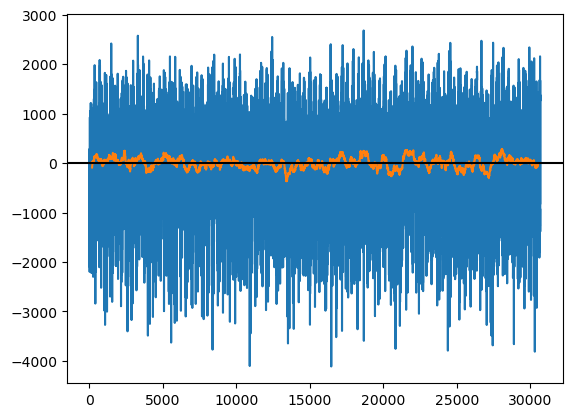

In [47]:
plt.plot(detrend_xr.sel(lat = 40,lon=270))
running_mean = detrend_xr.sel(lat = 40,lon=270).rolling(time=365, center=True).mean()
plt.plot(running_mean)
plt.axhline(np.mean(detrend_xr.sel(lat = 40,lon=270)),color='k')

In [108]:
clima_std_average_region_series

<xarray.Dataset>
Dimensions:            (day_of_year: 365)
Coordinates:
  * day_of_year        (day_of_year) int64 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    Z_climatology_std  (day_of_year) float64 653.6 654.5 655.4 ... 651.9 652.8

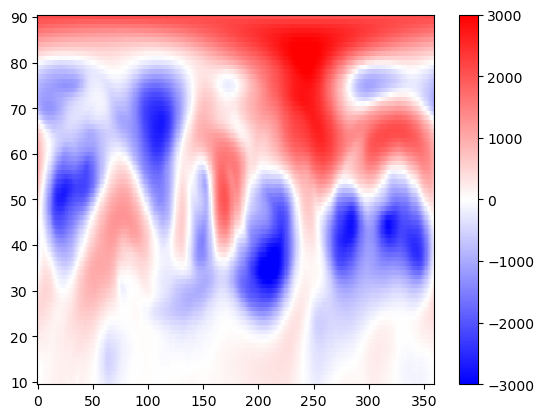

In [92]:
plt.pcolormesh(detrend_xr.lon,detrend_xr.lat,detrend_xr[0],vmin=-3000,vmax=3000,cmap='bwr')
plt.colorbar()

In [109]:
stdfull = std_anomalies.Z.std('time')
meanfull = std_anomalies.Z.mean('time')

In [112]:
ds_aies = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/DailyDetrendedStdAnoms_v2/Z500_ERA5_Region.nc')

In [134]:
example_field_aies = ds_aies.sel(time='2021-06-26').Z_anomalies
example_field = std_anomalies.sel(time='2021-06-26').Z
example_field_filtered = filtered_anoms.sel(time='2021-06-26')

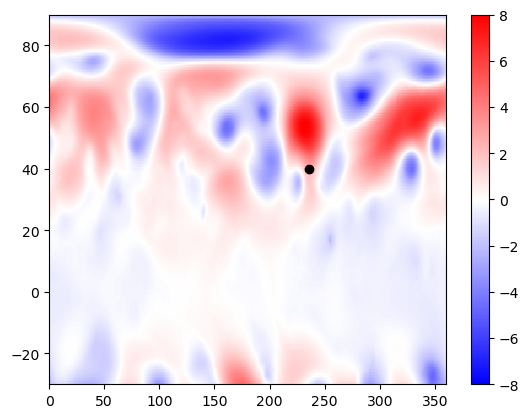

In [129]:
plt.pcolormesh(stdfull_aies.lon,stdfull_aies.lat,example_field_aies,vmin=-8,vmax=8,cmap='bwr')
plt.colorbar()
plt.scatter([-124+360],[40],color='k')


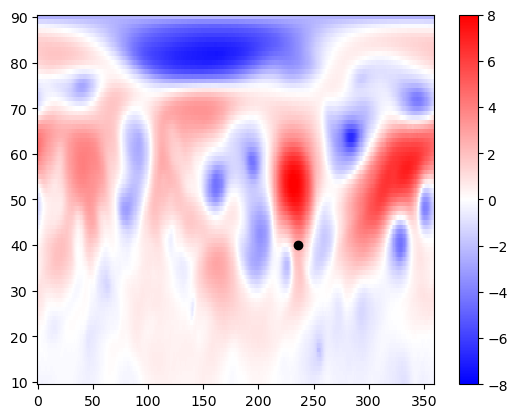

In [128]:
plt.pcolormesh(example_field.lon,example_field.lat,example_field,vmin=-8,vmax=8,cmap='bwr')
plt.colorbar()
plt.scatter([-124+360],[40],color='k')


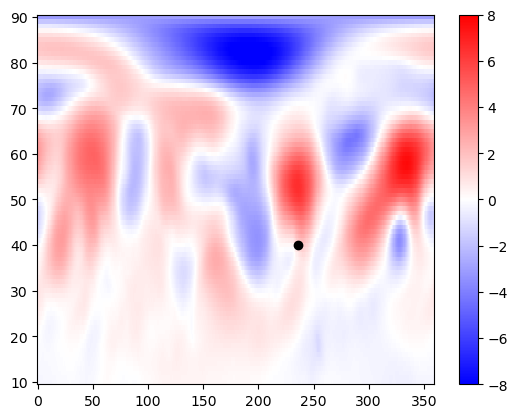

In [135]:
plt.pcolormesh(example_field.lon,example_field.lat,example_field_filtered,vmin=-8,vmax=8,cmap='bwr')
plt.colorbar()
plt.scatter([-124+360],[40],color='k')


In [116]:
stdfull_aies = ds_aies.Z_anomalies.std('time')
meanfull_aies = ds_aies.Z_anomalies.mean('time')

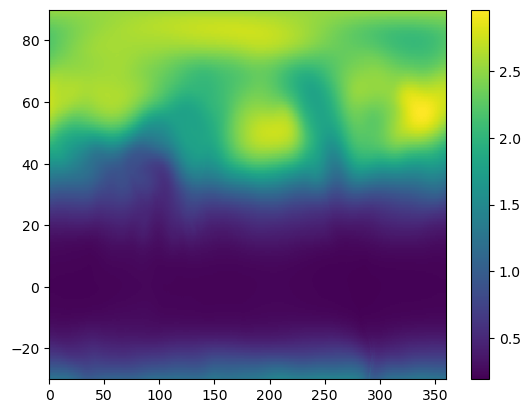

In [117]:
plt.pcolormesh(stdfull_aies.lon,stdfull_aies.lat,stdfull_aies)
plt.colorbar()

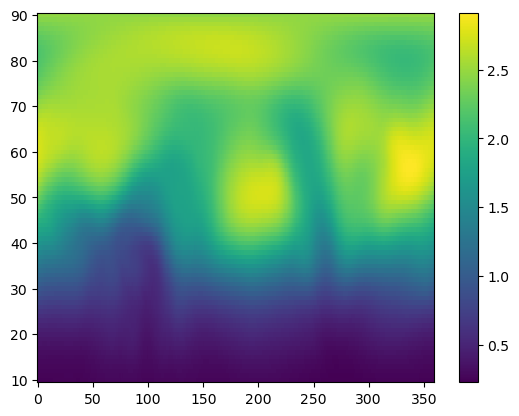

In [104]:
plt.pcolormesh(std_anomalies.Z.lon,std_anomalies.Z.lat,stdfull)
plt.colorbar()

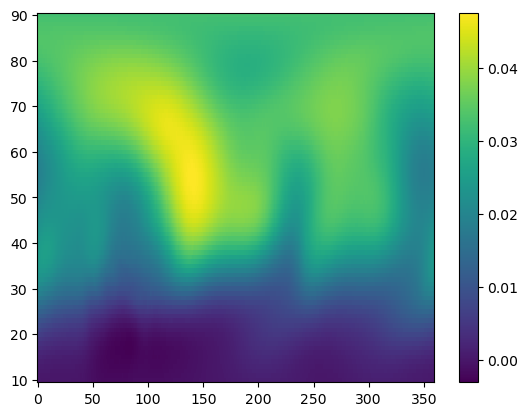

In [110]:
plt.pcolormesh(std_anomalies.Z.lon,std_anomalies.Z.lat,meanfull)
plt.colorbar()

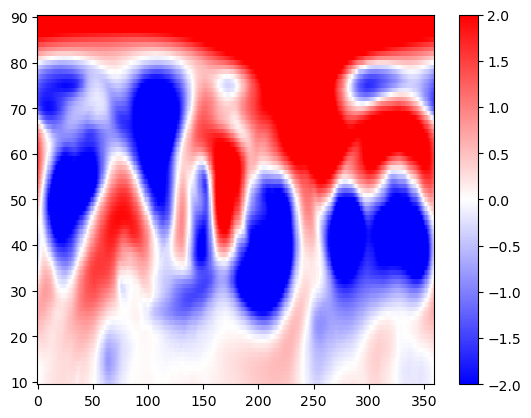

In [97]:
plt.pcolormesh(std_anomalies.Z.lon,std_anomalies.Z.lat,std_anomalies.Z[0],vmin=-2,vmax=2,cmap='bwr')
plt.colorbar()

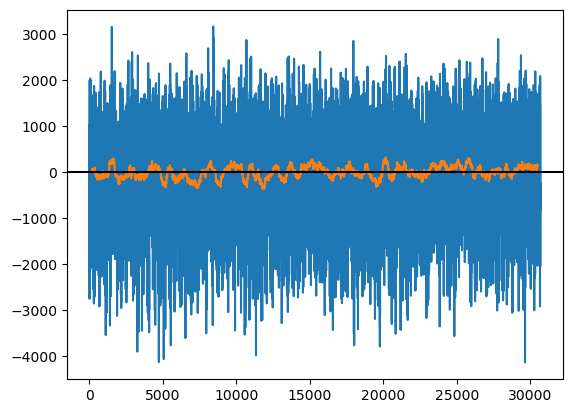

In [84]:
plt.plot(detrend_xr.isel(lat=40,lon=70))
running_mean = detrend_xr.isel(lat=40,lon=70).rolling(time=365, center=True).mean()
plt.plot(running_mean)
plt.axhline(np.mean(detrend_xr.isel(lat=40,lon=70)),color='k')

In [184]:
np.std(detrend_xr.isel(lat=30,lon=70))

<xarray.DataArray 'Z' ()>
array(2.94458846)
Coordinates:
    lat      int64 50
    lon      int64 250

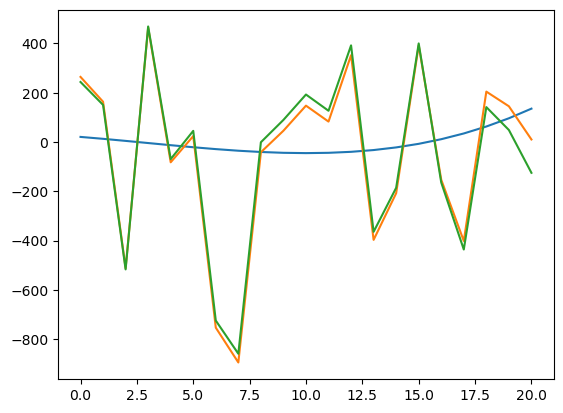

In [166]:
plt.plot(trend2d[:,0])
plt.plot(anoms_temp[:,0])
plt.plot(detrended_anoms_temp[:,0])

In [110]:
trend

array([33012.94806297, 33018.33729708, 33023.43766669, 33028.25674865,
       33032.80211984, 33037.08135713, 33041.10203739, 33044.87173749,
       33048.3980343 , 33051.68850468, 33054.75072551, 33057.59227365,
       33060.22072597, 33062.64365935, 33064.86865065, 33066.90327674,
       33068.75511449, 33070.43174077, 33071.94073244, 33073.28966639,
       33074.48611947, 33075.53766855, 33076.45189052, 33077.23636222,
       33077.89866054, 33078.44636234, 33078.88704449, 33079.22828386,
       33079.47765732, 33079.64274174, 33079.73111399, 33079.75035094,
       33079.70802945, 33079.61172639, 33079.46901864, 33079.28748307,
       33079.07469653, 33078.83823591, 33078.58567807, 33078.32459988,
       33078.06257821, 33077.80718993, 33077.5660119 , 33077.346621  ,
       33077.1565941 , 33077.00350806, 33076.89493976, 33076.83846606,
       33076.84166383, 33076.91210994, 33077.05738126, 33077.28505467,
       33077.60270702, 33078.01791519, 33078.53825604, 33079.17130645,
      

In [105]:
Xgroup

<xarray.DataArray 'Z' (time: 84, z: 9211)>
array([[57342.668, 57327.95 , 57314.76 , ..., 50259.543, 50274.594,
        50288.926],
       [57431.645, 57409.53 , 57385.125, ..., 50675.656, 50657.113,
        50639.062],
       [57556.66 , 57544.39 , 57531.566, ..., 48275.67 , 48274.62 ,
        48278.348],
       ...,
       [57658.14 , 57645.33 , 57638.67 , ..., 51079.19 , 51140.92 ,
        51205.13 ],
       [56429.293, 56346.293, 56278.938, ..., 50555.855, 50536.77 ,
        50518.176],
       [57927.066, 57926.496, 57926.047, ..., 50915.027, 50914.516,
        50912.94 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1941-01-01 ... 2023-01-01
  * z        (z) object MultiIndex
  * lat      (z) int64 20 20 20 20 20 20 20 20 20 ... 80 80 80 80 80 80 80 80 80
  * lon      (z) int64 180 181 182 183 184 185 186 ... 325 326 327 328 329 330

In [ ]:
iz=5000
anoms_temp = Xgroup.isel(z=iz)-np.mean(Xgroup.isel(z=iz))
norm_trend = trend - np.mean(trend)
detrended_temp = anoms_temp-norm_trend
std_temp = detrended_temp / np.std(detrended_temp)


In [101]:
Xgroup

<xarray.DataArray 'Z' (time: 84, z: 9211)>
array([[57342.668, 57327.95 , 57314.76 , ..., 50259.543, 50274.594,
        50288.926],
       [57431.645, 57409.53 , 57385.125, ..., 50675.656, 50657.113,
        50639.062],
       [57556.66 , 57544.39 , 57531.566, ..., 48275.67 , 48274.62 ,
        48278.348],
       ...,
       [57658.14 , 57645.33 , 57638.67 , ..., 51079.19 , 51140.92 ,
        51205.13 ],
       [56429.293, 56346.293, 56278.938, ..., 50555.855, 50536.77 ,
        50518.176],
       [57927.066, 57926.496, 57926.047, ..., 50915.027, 50914.516,
        50912.94 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1941-01-01 ... 2023-01-01
  * z        (z) object MultiIndex
  * lat      (z) int64 20 20 20 20 20 20 20 20 20 ... 80 80 80 80 80 80 80 80 80
  * lon      (z) int64 180 181 182 183 184 185 186 ... 325 326 327 328 329 330

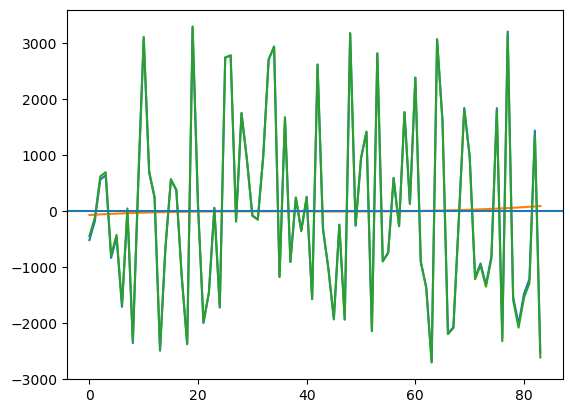

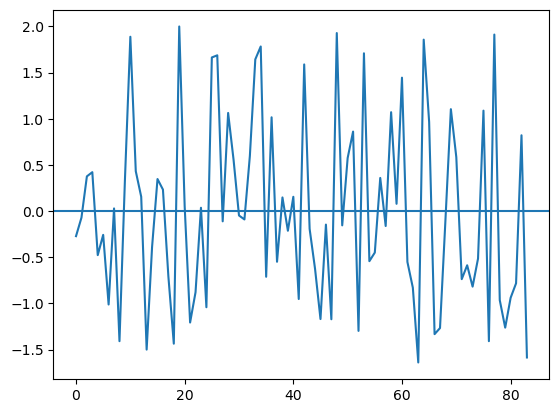

In [100]:

plt.plot(anoms_temp)
plt.plot(norm_trend)
plt.plot(detrended_temp)
plt.axhline(np.mean(anoms_temp-norm_trend))
plt.show()
plt.close('all')
plt.plot(std_temp)
plt.axhline(np.mean(std_temp))
plt.show()

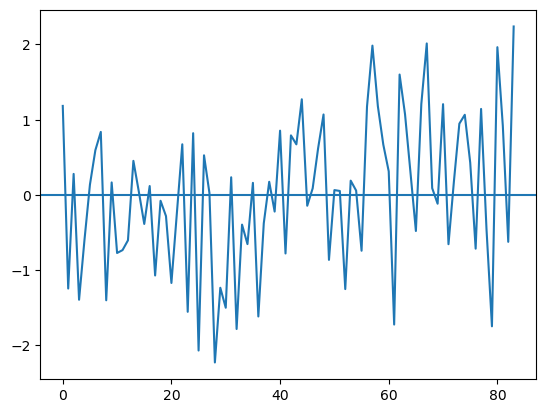

In [65]:
trend.shape

(84,)

In [ ]:
Xgroup - trend

In [62]:
Xgroup

<xarray.DataArray 'Z' (time: 84, z: 29160)>
array([[57328.3  , 57342.074, 57356.24 , ..., 51810.05 , 51810.05 ,
        51810.05 ],
       [57249.887, 57249.188, 57249.668, ..., 49636.75 , 49636.75 ,
        49636.75 ],
       [57284.953, 57287.12 , 57293.348, ..., 48501.83 , 48501.83 ,
        48501.83 ],
       ...,
       [57630.652, 57628.723, 57622.62 , ..., 50898.11 , 50898.11 ,
        50898.11 ],
       [57444.25 , 57438.51 , 57433.355, ..., 51529.25 , 51529.25 ,
        51529.25 ],
       [57528.06 , 57526.453, 57524.684, ..., 51405.234, 51405.234,
        51405.234]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1941-01-01 ... 2023-01-01
  * z        (z) object MultiIndex
  * lat      (z) int64 10 10 10 10 10 10 10 10 10 ... 90 90 90 90 90 90 90 90 90
  * lon      (z) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359

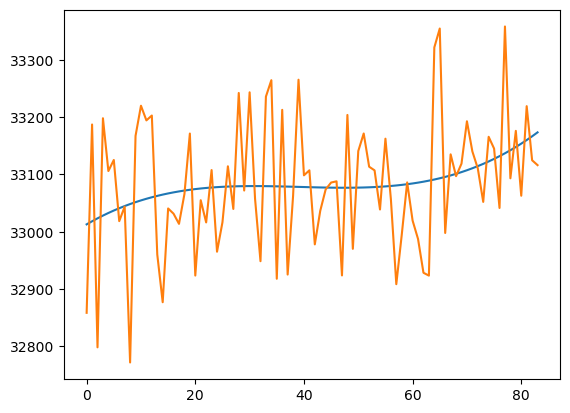

In [56]:
plt.plot(trend)
plt.plot(ens_group)

In [49]:
train_data

<xarray.DataArray (time: 30681)>
array([32858.66271775, 32906.6356606 , 32955.0607297 , ...,
       33267.42914243, 33256.89907987, 33219.50850291])
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31

In [41]:
data

<xarray.DataArray 'Z' (time: 30681, lat: 81, lon: 360)>
[894657960 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
  * lat      (lat) int64 10 11 12 13 14 15 16 17 18 ... 83 84 85 86 87 88 89 90
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

In [20]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'
dataset_raw = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')


In [ ]:
plt.plot(mean_series)

In [22]:
mean_series, trend_constant = get_trend_of_average_field(dataset_raw,'Z')

In [33]:
# Calculate the centered 365-day running mean
running_mean = mean_series.rolling(time=365, center=True).mean()

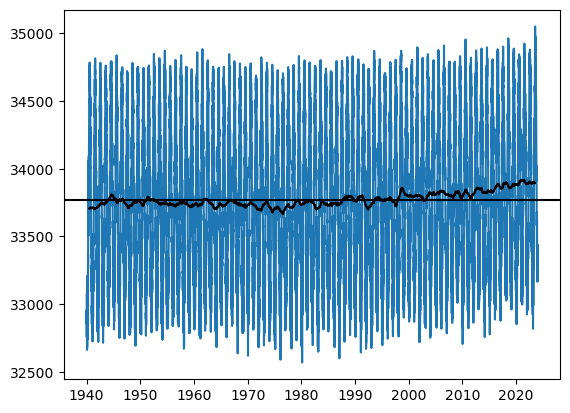

In [39]:
plt.plot(mean_series.time,mean_series)
plt.plot(mean_series.time,running_mean,color='k')
plt.axhline(np.mean(mean_series),color='k')


In [18]:
print (trend_constant*365*10/9.81,'m/decade')

1.747349659278377 m/decade


In [ ]:
anoms = detrend_obs(dataset.Z,dataset.Z)
std_anoms = standardize_anomalies_with_smoothed_std(anoms)
filtered_anoms = fourierfilter(std_anoms)
filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
filtered_anoms = filtered_anoms.drop_vars('dayofyear')
path_output_anoms = f'{path_origins}Z500Anoms_{name_reanalysis}_v2.nc'
filtered_anoms.to_netcdf(path_output_anoms)

In [14]:
dataset

<xarray.Dataset>
Dimensions:  (time: 30681, lat: 81, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
  * lat      (lat) int64 10 11 12 13 14 15 16 17 18 ... 83 84 85 86 87 88 89 90
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    Z        (time, lat, lon) float32 ...

In [3]:
def detrend_obs(data, train_data, npoly=3):
    '''
    detrend reanalysis using polynomial fit (for each doy) to the training mean
    
    data: [time, lat, lon] or [member, time]
        reanalysis to detrend 
    
    train_data: [time, lat, lon] or [time]
        ensemble mean 
    
    npoly: [int] 
        order of polynomial, default = 3rd order
    '''
    # stack lat and lon of ensemble mean data
    if len(train_data.shape) == 3:
        train_data = train_data.stack(z=('lat', 'lon'))
 
    # stack lat and lon of member data & grab doy information
    if len(data.shape) == 3:
        data = data.stack(z=('lat', 'lon'))
    temp = data['time.dayofyear']
    
    # grab every Xdoy from ensmean, fit npoly polynomial
    # subtract polynomial from every Xdoy from members
    detrend = []
    for label,ens_group in train_data.groupby('time.dayofyear'):
        Xgroup = data.where(temp == label, drop = True)
        
        curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)
        trend = polynomial.polyval(np.arange(0, ens_group.shape[0]), curve, tensor=True)
        if len(train_data.shape) == 2: #combined lat and lon, so now 2
            trend = np.swapaxes(trend,0,1) #only need to swap if theres a space dimension

        diff = Xgroup - trend
        detrend.append(diff)

    detrend_xr = xr.concat(detrend,dim='time').unstack()
    detrend_xr = detrend_xr.sortby('time')
    
    return detrend_xr

def smooth_standard_deviation(std_doy, window=60):
    # Extend the array by wrapping around for edge effects
    extended_std_doy = xr.concat([std_doy[-window:], std_doy, std_doy[:window]], dim='dayofyear')
    # Apply rolling mean and remove the extra days
    smoothed_std = extended_std_doy.rolling(dayofyear=window, center=True).mean()
    smoothed_std = smoothed_std[window:-window]
    return smoothed_std

def standardize_anomalies_with_smoothed_std(da):
    # Compute day of year
    doy = da['time'].dt.dayofyear
    
    # Group data by day of year and compute standard deviation
    std_doy = da.groupby(doy).std('time')
    
    # Smooth the standard deviation using a 60-day rolling average
    smoothed_std_doy = smooth_standard_deviation(std_doy, window=60)
    # return smoothed_std_doy
    # Standardize the anomalies by dividing by the smoothed standard deviation
    standardized_da = da.groupby(doy) / smoothed_std_doy
    
    return standardized_da

# # Example usage:
# # standardized_anomalies = standardize_anomalies_with_smoothed_std(da)

In [4]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'
dataset = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')
anoms = detrend_obs(dataset.Z,dataset.Z)
std_anoms = standardize_anomalies_with_smoothed_std(anoms)
filtered_anoms = fourierfilter(std_anoms)
filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
filtered_anoms = filtered_anoms.drop_vars('dayofyear')
path_output_anoms = f'{path_origins}Z500Anoms_{name_reanalysis}_v2.nc'
filtered_anoms.to_netcdf(path_output_anoms)

/glade/derecho/scratch/jhayron/tmp/ipykernel_214077/2618834057.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


# All the others

In [5]:
def compute_anoms_reanalysis(name_reanalysis):
    path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
    dataset = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')
    anoms = detrend_obs(dataset.Z,dataset.Z)
    std_anoms = standardize_anomalies_with_smoothed_std(anoms)
    filtered_anoms = fourierfilter(std_anoms)
    filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
    filtered_anoms = filtered_anoms.drop_vars('dayofyear')
    path_output_anoms = f'{path_origins}Z500Anoms_{name_reanalysis}_v2.nc'
    filtered_anoms.to_netcdf(path_output_anoms)

In [6]:
compute_anoms_reanalysis('JRA3Q')

/glade/derecho/scratch/jhayron/tmp/ipykernel_214077/2618834057.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [7]:
compute_anoms_reanalysis('MERRA2')

/glade/derecho/scratch/jhayron/tmp/ipykernel_214077/2618834057.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [8]:
compute_anoms_reanalysis('NCEP_NCAR')

/glade/derecho/scratch/jhayron/tmp/ipykernel_214077/2618834057.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [9]:
compute_anoms_reanalysis('NCEP_DOE')

/glade/derecho/scratch/jhayron/tmp/ipykernel_214077/2618834057.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [4]:
xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/Z500_ERA5.nc').Z[0]

<xarray.DataArray 'Z' (lat: 81, lon: 360)>
array([[57328.3  , 57342.074, 57356.24 , ..., 57286.574, 57300.156, 57314.832],
       [57324.324, 57337.02 , 57349.72 , ..., 57280.55 , 57294.688, 57309.95 ],
       [57317.875, 57329.676, 57342.176, ..., 57276.98 , 57291.188, 57305.49 ],
       ...,
       [51521.938, 51515.72 , 51509.582, ..., 51540.438, 51534.23 , 51528.082],
       [51686.98 , 51683.47 , 51680.   , ..., 51697.645, 51694.05 , 51690.51 ],
       [51810.05 , 51810.05 , 51810.05 , ..., 51810.05 , 51810.05 , 51810.05 ]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 1940-01-01
  * lat      (lat) int64 10 11 12 13 14 15 16 17 18 ... 83 84 85 86 87 88 89 90
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359